This note book is based entirely on a Kaggle jupyter notebook. https://www.kaggle.com/guoday/two-sigma-connect-rental-listing-inquiries/cv-statistics-edited-0-5346-score/notebook

In [68]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#input data
train_df=pd.read_json('C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\train.json\\train.json')
test_df=pd.read_json('C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\test.json\\test.json')

We create some basic additional features based on the initial variables.

In [69]:
#basic features
train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 
train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))


features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","price_t","num_photos", "num_features", "num_description_words","listing_id"]


We will create three levels of manager id valuation based on the number of low, medium and high interest for listing interest.

In [70]:
index=list(range(train_df.shape[0]))
random.shuffle(index)
a=[np.nan]*len(train_df)
b=[np.nan]*len(train_df)
c=[np.nan]*len(train_df)

for i in range(5):
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c



a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]
for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

#features_to_use.append('manager_level_low') 
#features_to_use.append('manager_level_medium') 
#features_to_use.append('manager_level_high')

Label encoding transformation of the categorical variables.

In [71]:
#categorical = ["display_address", "manager_id", "building_id", "street_address"]
categorical = ["manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

Introducing the neighbourhood variable.

In [177]:
#Skip this one

import shapefile

sf = shapefile.Reader("C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\ZillowNeighborhoods-NY\\ZillowNeighborhoods-NY.shp")

shapes = sf.shapes()
records = sf.records()

towns_values = [records[i][2] for i in range(len(records))]
neighb_values = [records[i][3] for i in range(len(records))]
west_values = [shapes[i].bbox[0] for i in range(len(records))]
south_values = [shapes[i].bbox[1] for i in range(len(records))]
east_values = [shapes[i].bbox[2] for i in range(len(records))]
north_values = [shapes[i].bbox[3] for i in range(len(records))]

west, south, east, north = -74.02, 40.64, -73.85, 40.86

neighbourhood_pd = pd.DataFrame({'Town' : towns_values,
                                 'Neighbourhood' : neighb_values,
                                 'West' : west_values,
                                 'South' : south_values,
                                 'East' : east_values,
                                 'North' : north_values})

neighbourhood_pd = neighbourhood_pd[neighbourhood_pd.Town == "New York"]
neighbourhood_pd = neighbourhood_pd.ix[(neighbourhood_pd.West >= west) & 
                                     (neighbourhood_pd.East <= east) & 
                                     (neighbourhood_pd.South >= south) & 
                                     (neighbourhood_pd.North <= north)]

neighbourhood_sorted_pd = neighbourhood_pd.sort_values(['West'])


neighbourhood_ls = []
for num in range(0, train_df.shape[0]):
    temp = neighbourhood_sorted_pd[(neighbourhood_sorted_pd.West<train_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.East>train_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.South<train_df.latitude.values[num]) &
                                   (neighbourhood_sorted_pd.North>train_df.latitude.values[num])]
    if temp.shape[0] > 0:
        neighbourhood_ls += [temp.Neighbourhood.values[0]]
    else:
        neighbourhood_ls += ["Other"]
    
train_df['neighbourhood'] = pd.Series(neighbourhood_ls, index=train_df.index)

neighbourhood_ls = []
for num in range(0, test_df.shape[0]):
    temp = neighbourhood_sorted_pd[(neighbourhood_sorted_pd.West<test_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.East>test_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.South<test_df.latitude.values[num]) &
                                   (neighbourhood_sorted_pd.North>test_df.latitude.values[num])]
    if temp.shape[0] > 0:
        neighbourhood_ls += [temp.Neighbourhood.values[0]]
    else:
        neighbourhood_ls += ["Other"]
    
test_df['neighbourhood'] = pd.Series(neighbourhood_ls, index=test_df.index)

Introducing the price_diff variable

In [178]:
# Skip this one
train_group_by = train_df[["bedrooms", "neighbourhood", "price"]].groupby(["bedrooms", "neighbourhood"]).median()
train_group_by = train_group_by.add_suffix('_median').reset_index()

train_df = train_df.merge(train_group_by, left_on=['bedrooms', 'neighbourhood'], right_on=['bedrooms', 'neighbourhood'], how='outer')
test_df = test_df.merge(train_group_by, left_on=['bedrooms', 'neighbourhood'], right_on=['bedrooms', 'neighbourhood'], how='left')

train_df["price_diff"] = train_df["price"] - train_df["price_median"]
test_df["price_diff"] = test_df["price"] - test_df["price_median"]

In [72]:
train_group_by = train_df[["bedrooms", "price"]].groupby(["bedrooms"]).median()
train_group_by = train_group_by.add_suffix('_median').reset_index()

train_df = train_df.merge(train_group_by, left_on=['bedrooms'], right_on=['bedrooms'], how='outer')
test_df = test_df.merge(train_group_by, left_on=['bedrooms'], right_on=['bedrooms'], how='left')

train_df["price_diff"] = train_df["price"] - train_df["price_median"]
test_df["price_diff"] = test_df["price"] - test_df["price_median"]

We will use the created date and will add the day of year, week of year and a number of other data related variables.

In [73]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date"]= train_df["created"].dt.date

train_df["dayofyear"] = train_df["created"].dt.dayofyear
train_df["weekofyear"] = train_df["created"].dt.weekofyear
train_df["weekday"] = train_df["created"].dt.weekday
train_df["hour"] = train_df["created"].dt.hour

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["date"]= test_df["created"].dt.date

test_df["dayofyear"] = test_df["created"].dt.dayofyear
test_df["weekofyear"] = test_df["created"].dt.weekofyear
test_df["weekday"] = test_df["created"].dt.weekday
test_df["hour"] = test_df["created"].dt.hour

Adding the count of apartments available for rent in each building.

In [74]:
building_id_group_by = train_df[["street_address", "building_id"]].groupby(["building_id"]).count()
building_id_group_by = building_id_group_by.add_suffix('_count').reset_index()

train_df = train_df.merge(building_id_group_by, left_on=['building_id'], right_on=['building_id'], how='inner')
test_df = test_df.merge(building_id_group_by, left_on=['building_id'], right_on=['building_id'], how='left')

Adding a density description variable for the location of the apartments.

In [75]:
train_df["pos"] = train_df.longitude.round(3).astype(str) + '_' + train_df.latitude.round(3).astype(str)
test_df["pos"] = test_df.longitude.round(3).astype(str) + '_' + test_df.latitude.round(3).astype(str)

vals = train_df['pos'].value_counts()
dvals = vals.to_dict()
train_df["density"] = train_df['pos'].apply(lambda x: dvals.get(x, vals.min()))
test_df["density"] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))

Assessing the manager skill based on the postings with high and low interest.

In [76]:
train_df['manager_skill'] = train_df['manager_level_high']*3 + train_df['manager_level_medium']*2 + train_df['manager_level_low']
test_df['manager_skill'] = test_df['manager_level_high']*3 + test_df['manager_level_medium']*2 + test_df['manager_level_low']

Adding a listing difference variable which is a reflection of the position under which a listing appears.

In [77]:
dayofyear_group_by = train_df[["listing_id", "dayofyear"]].groupby(["dayofyear"]).min()
dayofyear_group_by = dayofyear_group_by.add_suffix('_min').reset_index()

train_df = train_df.merge(dayofyear_group_by, left_on=['dayofyear'], right_on=['dayofyear'], how='left')
train_df['listing_difference'] = train_df['listing_id'] - train_df['listing_id_min']

test_df = test_df.merge(dayofyear_group_by, left_on=['dayofyear'], right_on=['dayofyear'], how='left')
test_df['listing_difference'] = test_df['listing_id'] - test_df['listing_id_min']

We are adding the newly created variable to features_to_use.

In [78]:
features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "listing_difference", "price","price_t","num_photos", "num_features", "num_description_words","listing_id"]

features_to_use.append("price_diff")
features_to_use.append("dayofyear")
features_to_use.append("weekofyear")
features_to_use.append("weekday")
features_to_use.append("hour")
#features_to_use.append("price_diff")
#features_to_use.append("longitude")
#features_to_use.append("latitude")
features_to_use.append("street_address_count")
features_to_use.append("manager_level_low")
features_to_use.append("manager_level_medium")
features_to_use.append("manager_level_high")
#features_to_use.append("pos")
features_to_use.append("density")
features_to_use.append("manager_skill")
#features_to_use.append("listing_difference")

Transforming the feature variable.

In [79]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

col_desc = ['desc_'+ i for i in tfidf.get_feature_names()] 
count_vect_df = pd.DataFrame(tr_sparse.todense(), columns=col_desc)
train_X_full = pd.concat([train_df[features_to_use].reset_index(),count_vect_df],axis=1)

count_vect_test_df = pd.DataFrame(te_sparse.todense(), columns=col_desc)
test_X_full = pd.concat([test_df[features_to_use].reset_index(),count_vect_test_df],axis=1)

0                                                     
1                                                     
2                                                     
3          Doorman Elevator Dishwasher Hardwood_Floors
4    Fireplace Dining_Room Balcony Doorman Elevator...
Name: features, dtype: object


Source for part of the code https://www.kaggle.com/ug2409/two-sigma-connect-rental-listing-inquiries/using-description-as-the-only-feature-72-cv

In [80]:
print(test_X_full.shape)
print(train_X_full.shape)

(74659, 223)
(49352, 223)


Now we will combine the newly created feature variables, which represent whether a feature is present or not, with the initial data frame

In [81]:
#train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
#test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
#print(train_X.shape, test_X.shape)

We will define the XGBoost function

In [82]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        print("Before train function")
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [83]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
i = 0
for dev_index, val_index in kf.split(range(train_X_full.shape[0])):
        #print(i)
        i = i + 1
        print(train_X_full.loc(dev_index))
        dev_X, val_X = train_X_full.loc[dev_index], train_X_full.loc[val_index]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        #print(log_loss(val_y, preds))
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.03299	test-mlogloss:1.03416
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:0.975647	test-mlogloss:0.978701
[2]	train-mlogloss:0.926607	test-mlogloss:0.931391
[3]	train-mlogloss:0.884001	test-mlogloss:0.890369
[4]	train-mlogloss:0.848156	test-mlogloss:0.85583
[5]	train-mlogloss:0.816305	test-mlogloss:0.825313
[6]	train-mlogloss:0.787896	test-mlogloss:0.79833
[7]	train-mlogloss:0.76298	test-mlogloss:0.774693
[8]	train-mlogloss:0.741012	test-mlogloss:0.754133
[9]	train-mlogloss:0.72127	test-mlogloss:0.735662
[10]	train-mlogloss:0.704632	test-mlogloss:0.719986
[11]	train-mlogloss:0.689604	test-mlogloss:0.705968
[12]	train-mlogloss:0.675631	test-mlogloss:0.693314
[13]	train-mlogloss:0.662766	test-mlogloss:0.68156
[14]	train-mlogloss:0.651056	test-mlogloss:0.671074
[15]	train-mlogloss:0.640788	test-mlogloss:0.662036
[16]	train-mlogloss:0.631256	test-

In [84]:
#preds, model = runXGB(train_X, train_y, test_X, num_rounds=300)
preds, model = runXGB(train_X_full, train_y, test_X_full, num_rounds=300)

out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter_results_v11.csv", index=False)

Before train function


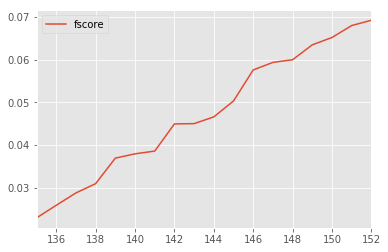

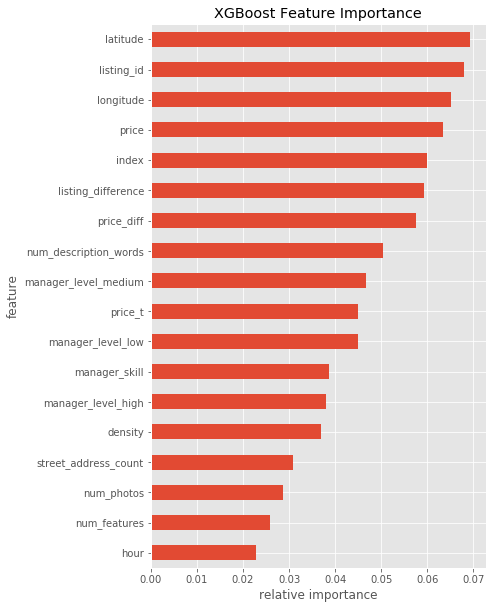

In [85]:
from matplotlib import pylab as plt
from xgboost import plot_tree

importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df[df['fscore']>0.02]

plt.style.use('ggplot') 

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [44]:
remove_vars = ["latitude", "longitude", "price_diff", "price", "num_description_words", "price_t"]

all_results_df = out_df
for var in remove_vars:
    print(var)
    train_X_partial = train_X_full.drop(var, axis=1)
    test_X_partial= test_X_full.drop(var, axis=1)
    print("before xgboost")
    preds, model = runXGB(train_X_partial, train_y, test_X_partial, num_rounds=300)
    print("sfter xgboost")
    out_df = pd.DataFrame(preds)
    out_df.columns = ["high", "medium", "low"]
    out_df["listing_id"] = test_df.listing_id.values
    if all_results_df.empty: 
        all_results_df = out_df
    else:
        all_results_df.append(out_df)

final_out_df = all_results_df.groupby(["listing_id"]).mean()
#out_df = out_df.add_suffix('_mean').reset_index()
final_out_df = final_out_df.reset_index()

final_out_df.to_csv("xgb_starter_results_v11.csv", index=False)    

latitude
before xgboost
Before train function
sfter xgboost
longitude
before xgboost
Before train function
sfter xgboost
price_diff
before xgboost
Before train function
sfter xgboost
price
before xgboost
Before train function
sfter xgboost
num_description_words
before xgboost
Before train function
sfter xgboost
price_t
before xgboost
Before train function
sfter xgboost


Predicting and saving the output.

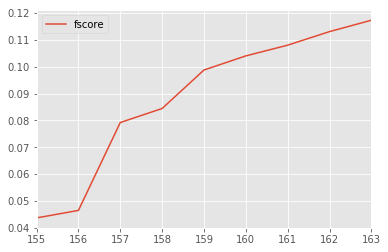

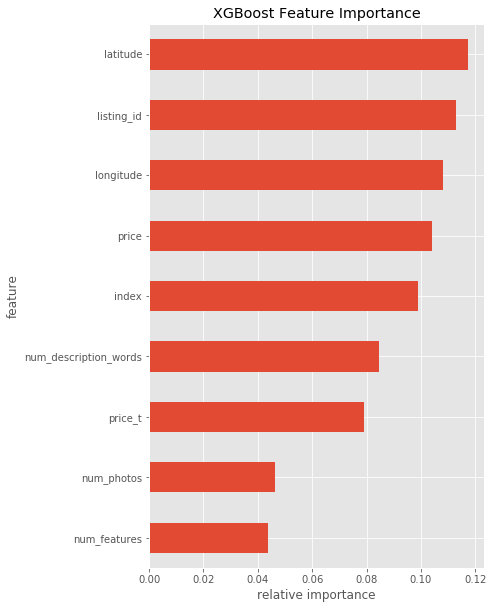

In [126]:
from matplotlib import pylab as plt
from xgboost import plot_tree

importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df[df['fscore']>0.02]

plt.style.use('ggplot') 

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()
